In [1]:
#This is only siple example. It DOES NOT DO state-of-art image matching, not even close, because it is lacking RANSAC
import torch
import torch.nn as nn
import numpy as np
import sys
import os
import time

from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from SparseImgRepresenter import ScaleSpaceAffinePatchExtractor
from LAF import denormalizeLAFs, LAFs2ell, abc2A
from Utils import line_prepender
from architectures import AffNetFast
from HardNet import HardNet

USE_CUDA = False

### Initialization
AffNetPix = AffNetFast(PS = 32)
weightd_fname = '../../pretrained/AffNet.pth'

checkpoint = torch.load(weightd_fname)
AffNetPix.load_state_dict(checkpoint['state_dict'])

AffNetPix.eval()
    
detector = ScaleSpaceAffinePatchExtractor( mrSize = 5.192, num_features = 3000,
                                          border = 5, num_Baum_iters = 1, 
                                          AffNet = AffNetPix)
descriptor = HardNet()
model_weights = '../../HardNet++.pth'
hncheckpoint = torch.load(model_weights)
descriptor.load_state_dict(hncheckpoint['state_dict'])
descriptor.eval()
if USE_CUDA:
    detector = detector.cuda()
    descriptor = descriptor.cuda()

In [3]:
#Image loading
try:
    input_img_fname1 = 'img/kpi1.png'#sys.argv[1]
    input_img_fname2 = 'img/kpi2.png'#sys.argv[2]
    output_img_fname = 'kpi_match.png'#sys.argv[3]
except:
    print "Cannot find images"
    sys.exit(1)

def load_grayscale_var(fname):
    img = Image.open(fname).convert('RGB')
    img = np.mean(np.array(img), axis = 2)
    var_image = torch.autograd.Variable(torch.from_numpy(img.astype(np.float32)), volatile = True)
    var_image_reshape = var_image.view(1, 1, var_image.size(0),var_image.size(1))
    if USE_CUDA:
        var_image_reshape = var_image_reshape.cuda()
    return var_image_reshape

img1 = load_grayscale_var(input_img_fname1)
img2 = load_grayscale_var(input_img_fname2)

## Detection and description
def get_geometry_and_descriptors(img, det, desc):
    with torch.no_grad():
        LAFs, resp = det(img, do_ori = True)
        patches = detector.extract_patches_from_pyr(LAFs, PS = 32)
        descriptors = descriptor(patches)
    return LAFs, descriptors


LAFs1, descriptors1 = get_geometry_and_descriptors(img1, detector, descriptor)
LAFs2, descriptors2 = get_geometry_and_descriptors(img2, detector, descriptor)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


1.12497711182 detection multiscale
affnet_time 3.79014706612
pe_time 0.19198179245
3.99200606346 affine shape iters
0.942224025726 detection multiscale
affnet_time 3.06612992287
pe_time 0.193987131119
3.27037096024 affine shape iters


In [4]:
print LAFs1.shape
print descriptors1.shape
#Now you can save descriptors and use them for matching, or whereever you need.

torch.Size([3000, 2, 3])
torch.Size([3000, 128])


In [5]:
#Bruteforce matching with SNN threshold
from Losses import distance_matrix_vector

SNN_threshold = 0.8

dist_matrix = distance_matrix_vector(descriptors1, descriptors2)
min_dist, idxs_in_2 = torch.min(dist_matrix,1)
dist_matrix[:,idxs_in_2] = 100000;# mask out nearest neighbour to find second nearest
min_2nd_dist, idxs_2nd_in_2 = torch.min(dist_matrix,1)
mask = (min_dist / (min_2nd_dist + 1e-8)) <= SNN_threshold

tent_matches_in_1 = indxs_in1 = torch.autograd.Variable(torch.arange(0, idxs_in_2.size(0)), requires_grad = False)[mask]
tent_matches_in_2 = idxs_in_2[mask]

tent_matches_in_1 = tent_matches_in_1.data.cpu().long()
tent_matches_in_2 = tent_matches_in_2.data.cpu().long()

#Note, that you probably what to match descriptors by FLANN kdtree matcher from OpenCV for efficiency
#instead of bruteforce matching


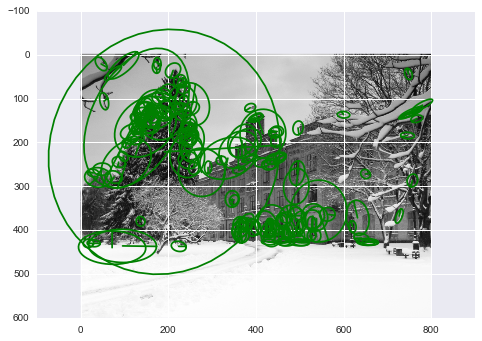

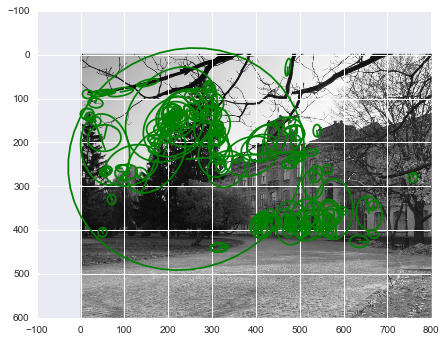

In [6]:
%matplotlib inline
from LAF import visualize_LAFs
import seaborn as sns
visualize_LAFs(img1.cpu().numpy().squeeze(), LAFs1[tent_matches_in_1,:,:].cpu().numpy().squeeze(), 'g')
visualize_LAFs(img2.cpu().numpy().squeeze(), LAFs2[tent_matches_in_2,:,:].cpu().numpy().squeeze(), 'g')

#Here only tentative matches are shown. Usually one use geometric verification by homography RANSAC, like 
# https://github.com/ducha-aiki/mods/tree/linux/degensac

#OpenCV RANSAC is rather bad, but better than nothing.
